In [29]:
from SurfaceQ import *
import matplotlib.pyplot as plt

The main class that the python module SurfaceQ defines is the ```RotatedSurfaceCode``` class. Calling the constructor defines a rotated surface code of size $k_{0} \times k_{1}$, initialized to a logical state (as an optional parameter). If no logical state is given, the code is initialized to logical zero (i.e. the ground state of the code system). 


In [30]:
surfacecode = RotatedSurfaceCode(9,9)

To visualize the rotated surface code, the ```RotatedSurfaceCode``` class has a draw function, which is essentially a wrapper for the draw function provided by NetworkX. We can pass in a "mode parameter", which can be "primal", "X" or "Z". If  ```mode = 'primal' ```, then NetworkX will draw the primal lattice of the surface code, if ```mode = 'X' ``` or ``` mode = 'Z' ```, then NetworkX will draw the corresponding Tanner graph (i.e. the Tanner graph corresponding to $X$ checks or the Tanner graph corresponding to $Z$ checks). Furthermore, there is an optional ```coords``` parameter: if we set ```coords = 'flat' ```, then the data nodes will be labelled by their index with respect to dictionary ordering of the lattice node coordinates. This is also the ordering that qubit registers are added onto the quantum circuit initializing the surface code. If we do not specify this parameter, then the data nodes are given by the lattice coordinates of the nodes in the primal lattice. 

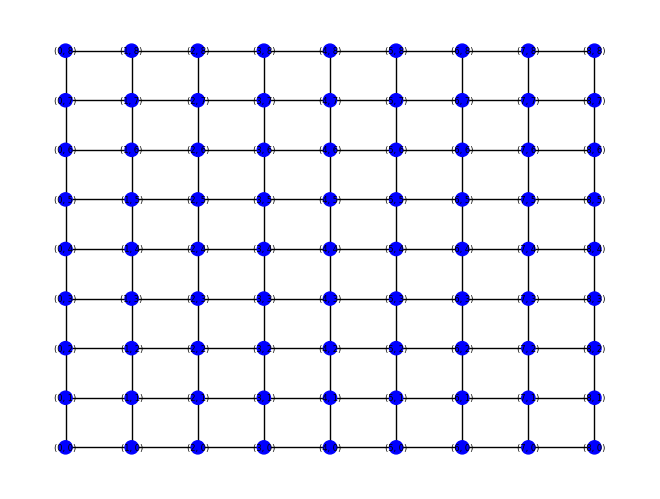

In [31]:
surfacecode.draw('primal')

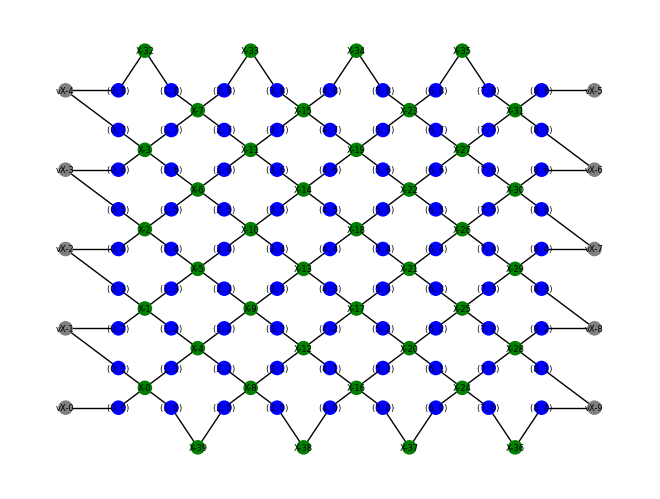

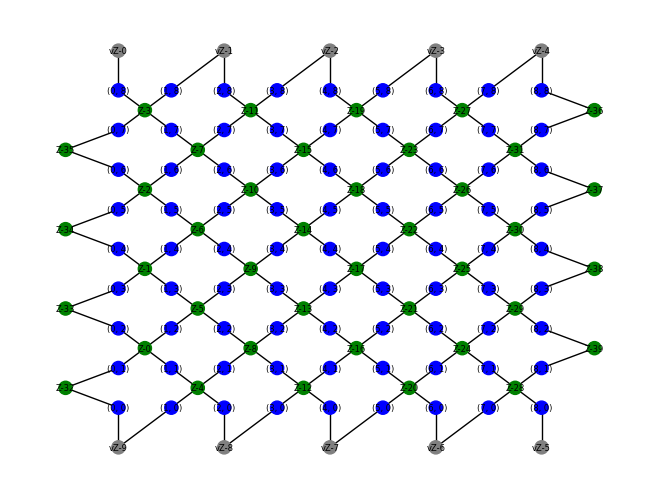

In [32]:
surfacecode.draw('X')
plt.pause(1)
surfacecode.draw('Z')


The visualizations provided by the SurfaceQ package may prove to be useful for educational purposes. Below, we demonstrate visualizations for both the Union-Find decoding algorithm and the Minimium-weight-perfect-matching decoding algorithms. 

-----

Let us breakdown the Union-Find decoding algorithm and illustrate some of the steps involved.

First, we run the surface code through a simulated depolarizing channel. We can turn on a ```report option``` parameter to print out the affected qubits.  Below, we will simulate a 10% physical error rate.



In [33]:
depolarizing_channel(surfacecode.LatticeCircuit, surfacecode.DataQubits, 0.10, print_option=True)

X on <Qubit register=(1, "(0, 4)"), index=0>
Z on <Qubit register=(1, "(0, 7)"), index=0>
Z on <Qubit register=(1, "(2, 5)"), index=0>
Y on <Qubit register=(1, "(3, 8)"), index=0>
Y on <Qubit register=(1, "(4, 7)"), index=0>
Y on <Qubit register=(1, "(5, 7)"), index=0>
Y on <Qubit register=(1, "(6, 3)"), index=0>
Y on <Qubit register=(1, "(7, 8)"), index=0>


Next, we measure syndromes and record the positions of the ancilla qubits in excitation

In [34]:
positions = surfacecode.syndrome_measurement('X', readout=True )
print( positions )

['X-3', 'X-6', 'X-10', 'X-21', 'X-23', 'X-25', 'X-31', 'X-33', 'X-35']


The Union-Find algorithm runs in rounds: a single round consists of a "growth phase", followed by a "fusion phase". These rounds run until there are no longer any active clusters of odd parity. If we call ```RotatedSurfaceCode.UnionFind_decode``` with the optional ```display``` parameter set to ```True```, then the method will also produce NetworkX visualizations of the state of the clusters after each round (beginning with the initialization of clusters to consist only of the excited ancilla nodes given by ```positions``` above).

initial state of clusters:


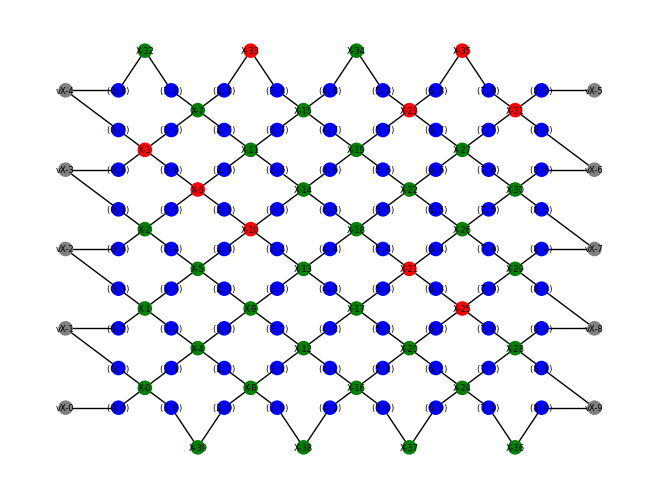

state after round 1:


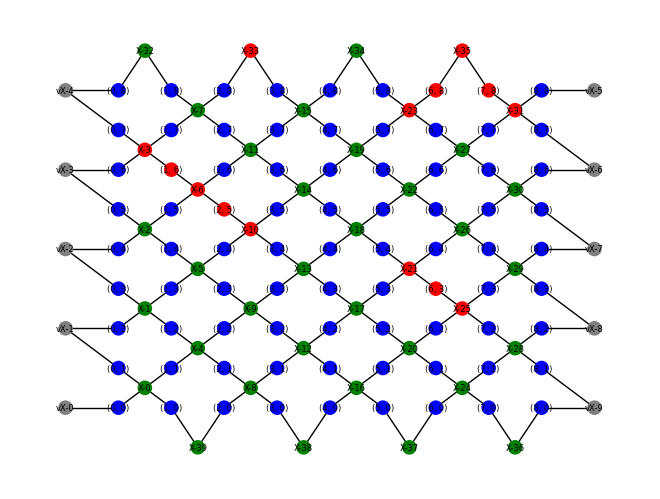

state after round 2:


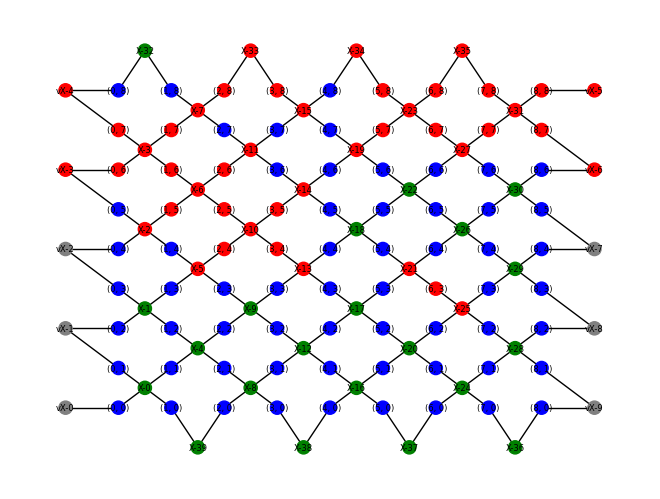

In [35]:
surfacecode.UnionFind_decode('X', positions, display=True)

Now, we repeat the steps above with Z stabilizer measurements.

In [36]:
positions = surfacecode.syndrome_measurement('Z', readout=True )
print( positions )

['Z-1', 'Z-11', 'Z-15', 'Z-21', 'Z-23', 'Z-25', 'Z-27', 'Z-34']


initial state of clusters:


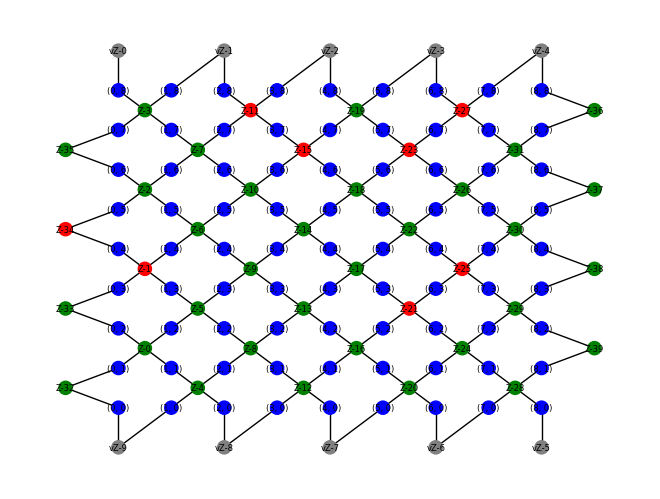

state after round 1:


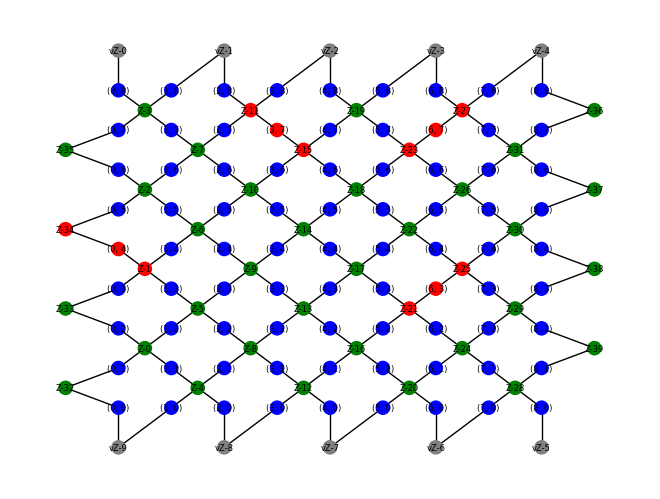

In [37]:
surfacecode.UnionFind_decode('Z', positions, display=True)

Running ```RotatedSurfaceCode.single_round(p_error, error_type, decoder_option)``` with ```decoder_option = union-find``` will run a full cycle of error channel -> syndrome measurement -> Union-Find decoding -> measure final logical state. The Jupyter notebook [SurfaceQdemo2.ipynb](SurfaceQdemo2.ipynb) demonstrates some bulk error cycle simulations and records some success rate statistics for respective decoders.

-----------------

Next, we visualize the minimum weight perfect matching decoding algorithm.

In [38]:
surfacecode = RotatedSurfaceCode(9,9)

In [39]:
depolarizing_channel(surfacecode.LatticeCircuit, surfacecode.DataQubits, 0.10, print_option=True)

X on <Qubit register=(1, "(0, 7)"), index=0>
Y on <Qubit register=(1, "(1, 7)"), index=0>
Z on <Qubit register=(1, "(3, 4)"), index=0>
X on <Qubit register=(1, "(4, 4)"), index=0>
Y on <Qubit register=(1, "(4, 8)"), index=0>
X on <Qubit register=(1, "(5, 4)"), index=0>
Y on <Qubit register=(1, "(7, 0)"), index=0>
Y on <Qubit register=(1, "(7, 4)"), index=0>


In [40]:
positions = surfacecode.syndrome_measurement('X', readout=True )
print(positions)

['X-3', 'X-7', 'X-10', 'X-13', 'X-15', 'X-24', 'X-26', 'X-29', 'X-34', 'X-36']


Initial state of MWPM decoding for X stabilizer excitations. Ancilla qubits in excitation:
Minimum weight perfect matchings:


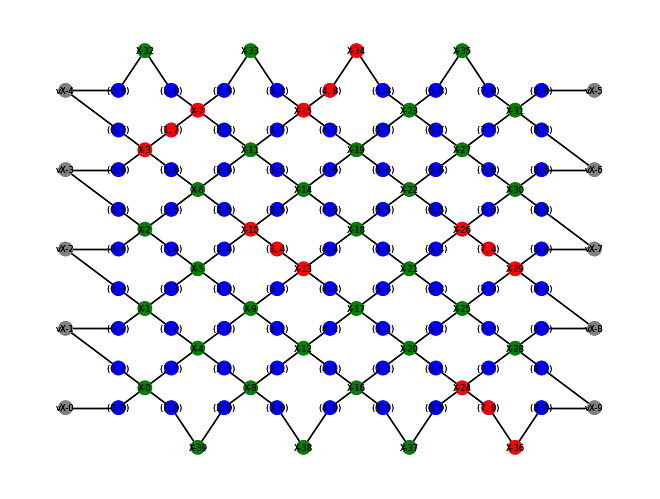

In [41]:
surfacecode.MWPM_decode('X', positions, display=True)

In [42]:
positions = surfacecode.syndrome_measurement('Z', readout=True )
print(positions)

['Z-7', 'Z-14', 'Z-19', 'Z-22', 'Z-25', 'Z-28', 'Z-30', 'Z-35']


Initial state of MWPM decoding for Z stabilizer excitations. Ancilla qubits in excitation:
Minimum weight perfect matchings:


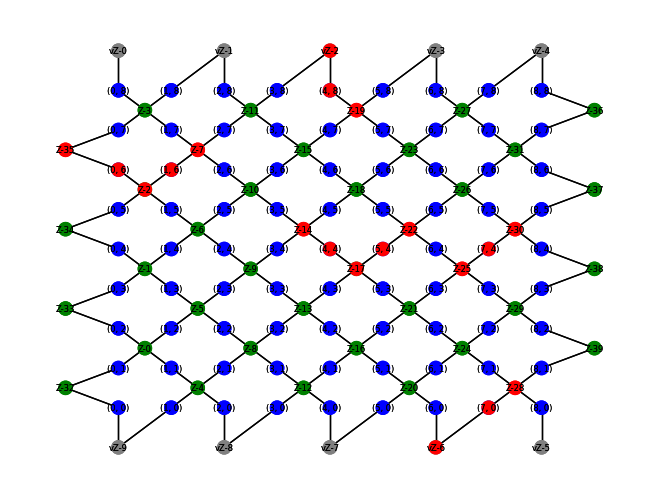

In [43]:
surfacecode.MWPM_decode('Z', positions, display=True)

Running ```RotatedSurfaceCode.single_round(p_error, error_type, decoder_option)``` with ```decoder_option = MWPM``` will run a full cycle of error channel -> syndrome measurement -> MWPM decoding -> measure final logical state. The Jupyter notebook [SurfaceQdemo2.ipynb](SurfaceQdemo2.ipynb) demonstrates some bulk error cycle simulations and records some success rate statistics for respective decoders.